In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/alternate/sample_mapping.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
df_whole = pd.read_csv('/cellar/users/ramarty/Data/kir/components/tcga/kir_four_random_counts.csv', index_col=0)
#df_whole = df_whole.ix[[x for x in df_whole.index if x not in sorta_low_coverage_patients]]

In [3]:
df_whole.shape

(10292, 26803)

In [4]:
capture_kits = capture_kits[capture_kits.SHORT_ID.isin(df_whole.index)]

plotting_df = pd.DataFrame(capture_kits.KIT.value_counts()).reset_index()

In [5]:
plotting_df.columns = ['capture_kit', 'Size']

In [6]:
plotting_df = plotting_df.sort_values('Size', ascending=False)

plotting_df

,capture_kit,Size
0,Agilent Custom,5885
1,Nimblegen HGSC,1339
2,Nimblegen.SQEZ2,1322
3,Nimblegen hg18,566
4,Nimblegen.SQEZ3,205
5,Sureselect.38,161


In [7]:
def get_pop(x):
    try:
        return list(capture_kits[capture_kits.SHORT_ID == x].KIT)[0]
    except:
        return ''

In [8]:
def get_tissue(x):
    try:
        return list(tissue_df.ix[x])[0]
    except:
        return ''

In [9]:
def get_capture_kit(x):
    try:
        return list(capture_kits[capture_kits.SHORT_ID == x].KIT)[0]
    except:
        return ''

In [10]:
def unsupervised_clustering(df, learner, category):
    if learner == 'tsne':
        model = TSNE(n_components=2, random_state=0)
        TSNEs = model.fit_transform(df)
    elif learner == 'pca':
        pca = PCA(n_components=2)
        TSNEs = pca.fit_transform(df)
    
    tsne_df = pd.DataFrame(TSNEs)
    tsne_df.columns = ['tsne1', 'tsne2']
    tsne_df['sample'] = df.index
    
    if category == 'population':
        tsne_df['population'] = tsne_df['sample'].apply(get_pop)
        tsne_df = tsne_df[tsne_df.population.isin(large_populations)]
        palette = sns.color_palette("hls", len(plotting_df.Population))
        colors = {}
        for i, population in enumerate(plotting_df.Population):
            colors[population] = palette[i]
        tsne_df['color'] = tsne_df.population.map(colors)
    elif category == 'tissue':
        tsne_df['tissue'] = tsne_df['sample'].apply(get_tissue)
        palette = sns.color_palette("hls", len(tsne_df['tissue'].unique()))
        colors = {}
        for i, tissue in enumerate(set(tsne_df.tissue)):
            colors[tissue] = palette[i]
        tsne_df['color'] = tsne_df.tissue.map(colors)
    elif category == 'capture_kit':
        tsne_df['capture_kit'] = tsne_df['sample'].apply(get_capture_kit)
        palette = sns.color_palette("hls", len(tsne_df['capture_kit'].unique()))
        colors = {}
        for i, capture_kit in enumerate(set(tsne_df.capture_kit)):
            colors[capture_kit] = palette[i]
        tsne_df['color'] = tsne_df.capture_kit.map(colors)
    
    plt.figure(figsize=(6,6))
    plt.scatter(tsne_df.tsne1, tsne_df.tsne2, c=tsne_df.color, lw = 0, alpha=0.5, s=20)
    
    return tsne_df

## Dimension reduction

Gene counts

In [11]:
# should be based on frequencies instead of total counts
#totals = df_whole[four_mers].sum(axis=1)
#for mer in four_mers:
#    df_whole[mer] = df_whole[mer] / totals

In [12]:
# get the sums across gene

In [13]:
sums = []
for gene in all_kmer_genes:
    sums.append(list(df_whole[kmers[30][gene]].sum(axis=1)))

In [14]:
gene_values = pd.DataFrame(sums).transpose()
gene_values.index = df_whole.index
gene_values.columns = all_kmer_genes

In [15]:
# normalize
totals = gene_values.sum(axis=1)
for gene in all_kmer_genes:
    gene_values[gene] = gene_values[gene] / totals

In [16]:
gene_values = gene_values.dropna()

In [17]:
gene_values.head()

,KIR2DP1,KIR2DS4,KIR2DS5,KIR2DS2,KIR2DS3,KIR2DL1,KIR2DL5,KIR2DL4,KIR3DL2,KIR3DL3,KIR3DP1
TCGA-TM-A84O,0.114441,0.099872,0.000043,0.000000,0.000036,0.014591,0.076900,0.208182,0.114053,0.163044,0.208836
TCGA-BF-AAP2,0.106568,0.110293,0.000000,0.000026,0.000020,0.012986,0.069658,0.213922,0.109782,0.162671,0.214073
TCGA-EJ-7794,0.076565,0.075197,0.031963,0.017225,0.000215,0.012176,0.217044,0.136163,0.122587,0.181690,0.129176
TCGA-CV-A45Q,0.079306,0.045499,0.029601,0.014963,0.048404,0.012435,0.242180,0.161760,0.081778,0.130197,0.153877
TCGA-DH-5140,0.060895,0.124341,0.000000,0.022439,0.000074,0.008390,0.062401,0.232859,0.112665,0.172958,0.202978


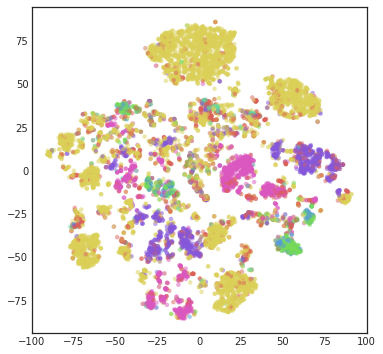

In [21]:
processed_df = unsupervised_clustering(gene_values, 'tsne', 'capture_kit')

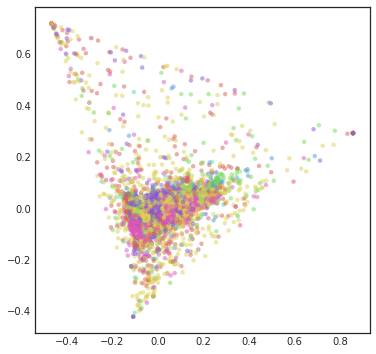

In [20]:
processed_df = unsupervised_clustering(gene_values, 'pca', 'capture_kit')

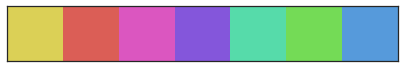

['Agilent Custom',
 '',
 'Nimblegen.SQEZ2',
 'Nimblegen HGSC',
 'Sureselect.38',
 'Nimblegen hg18',
 'Nimblegen.SQEZ3']

In [22]:
cp = processed_df.drop_duplicates(['capture_kit', 'color'])
sns.palplot(cp.color, size=1)
plt.show()
list(cp.capture_kit)

In [35]:
merged = pd.merge(cp, plotting_df, on='capture_kit')

In [37]:
merged.head()

,tsne1,tsne2,sample,capture_kit,color,Size
0,-18.250937,71.575806,TCGA-TM-A84O,Agilent Custom,"(0.86, 0.8169142857142857, 0.33999999999999997)",5885
1,38.561321,-11.187527,TCGA-IG-A51D,Nimblegen.SQEZ2,"(0.86, 0.33999999999999997, 0.7545142857142858)",1322
2,26.463398,31.773462,TCGA-AA-A01D,Nimblegen HGSC,"(0.5197714285714281, 0.33999999999999997, 0.86)",1339
3,25.788788,-54.497929,TCGA-24-1425,Sureselect.38,"(0.33999999999999997, 0.86, 0.6683428571428571)",161
4,-46.821629,34.250053,TCGA-E2-A1IJ,Nimblegen hg18,"(0.4573714285714283, 0.86, 0.33999999999999997)",566


([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

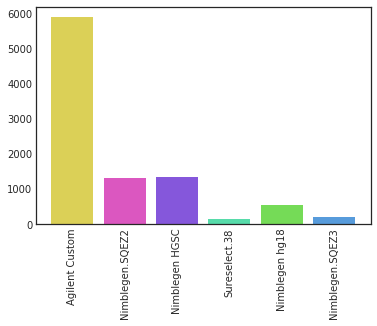

In [45]:
plt.bar(merged.capture_kit, merged.Size, color=merged.color)
plt.xticks(rotation=90)

Four mer counts

In [23]:
totals = df_whole[four_mers].sum(axis=1)
for mer in four_mers:
    df_whole[mer] = df_whole[mer] / totals

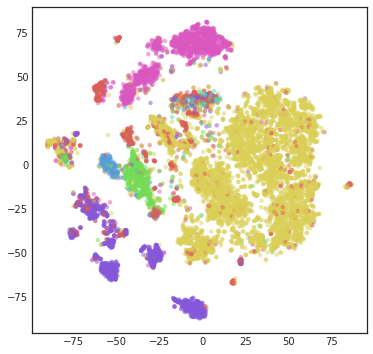

In [24]:
processed_df = unsupervised_clustering(df_whole[four_mers], 'tsne', 'capture_kit')

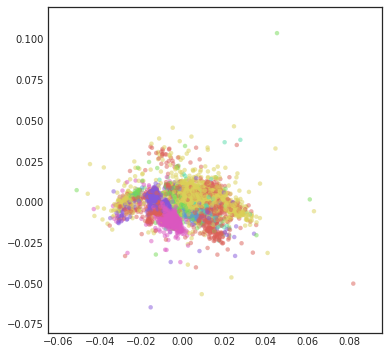

In [25]:
processed_df = unsupervised_clustering(df_whole[four_mers], 'pca', 'capture_kit')

### Random genes

In [12]:
random_genes = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/kmers/reference_genes/random_genes.100.txt').readlines()]
len(random_genes)

9936

In [13]:
random_gene_assignments = pickle.load(open('/cellar/users/ramarty/Data/kir/kmers/reference_genes/random_gene_assignments.p'))

In [18]:
totals = df_whole[random_genes].sum(axis=1)
for gene in random_gene_assignments.keys():
    df_whole[gene] = df_whole[random_gene_assignments[gene]].sum(axis=1) / totals

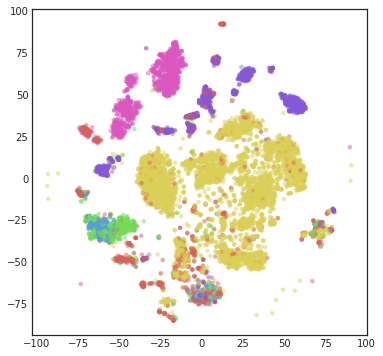

In [22]:
processed_df = unsupervised_clustering(df_whole[random_gene_assignments.keys()].dropna(), 
                                       'tsne', 'capture_kit')

In [24]:
processed_df.to_csv('/cellar/users/ramarty/Data/kir/TCGA/data_frames/tsne.random_genes.csv')

In [ ]:
# output processed_df to dataframe, use in coverage_cutoffs